 - combinar las tablas
 - limpiar datos
 - combinar las columnas title, brand, summary, description en una nueva columna
 - tokenizar la nueva columnas combinada
 - calcular similitud con la similitud de los items tokenizados del coseno
 - los que son muy similares los eliminamos de la lista
 - agarramos algunos items de la lista y calculamos el mean del overall
 - ordenamos nuevamente descendentemente pero esta vez basados en el overall mean => lista2
 - recomendamos los 10 primeros de la lista 2



In [70]:
import nltk
import json
import pandas as pd
import gzip
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
PATH = 'C:/Users/coraj/Documents/fuzzy-recommendation-system-/AMAZON_FASHION.json.gz'

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF(PATH)

In [72]:
PATH = 'C:/Users/coraj/Documents/fuzzy-recommendation-system-/meta_AMAZON_FASHION.json.gz'

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df_meta = getDF(PATH)

In [73]:
df_meta.shape

(186637, 16)

In [74]:
df_meta['asin'].nunique()

186194

notamos que hay productos que no son unicos, arreglamos eso

In [75]:
df_meta= df_meta.drop_duplicates(subset='asin', keep='first')
df_meta.shape

(186194, 16)

creamos una nueva columnas que contiene la informacion que necesitamos para encontrar items similares

In [76]:
columns_to_combine = ['title', 'brand', 'summary', 'description', 'expliota']
existing_columns = [col for col in columns_to_combine if col in df_meta.columns]

if existing_columns:
    # Al menos una de las columnas en 'existing_columns' existe en el df_metaFrame 'df_meta'.
    # Puedes combinar las columnas existentes y crear la nueva columna 'combined_text'.
    df_meta['combined_text'] = df_meta[existing_columns].apply(lambda row: ' '.join(str(val) for val in row), axis=1)

Text(0, 0.5, 'Count')

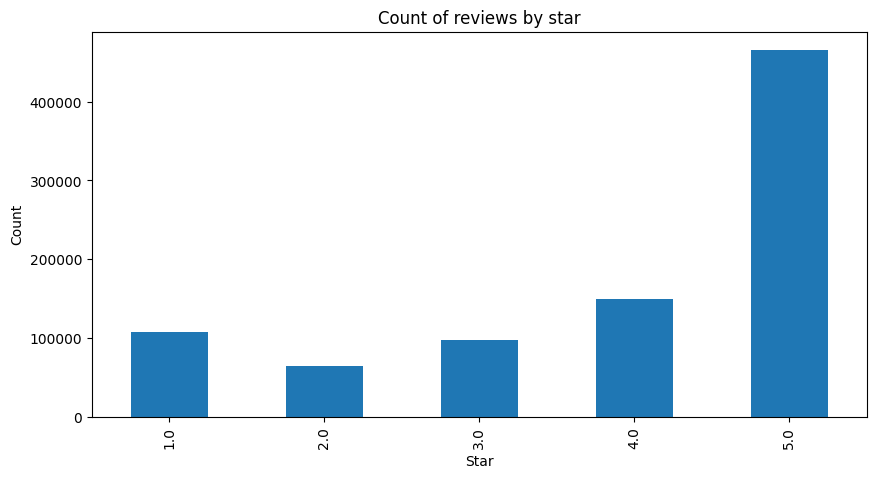

In [77]:
ax = df['overall'].value_counts().sort_index().plot(kind='bar', title="Count of reviews by star",figsize=(10, 5))
ax.set_xlabel("Star")
ax.set_ylabel("Count")


notamos que los reviews estan sesgados hacia 5 estrellas

calculamos el promedio de estrellas por producto y creamos una nueva columna en el df_metaFrame 'df_meta' para almacenar el promedio de estrellas por producto.

In [78]:
# Calcular el "rating score" promedio por 'asin'
rating_score = df.groupby('asin')['overall'].mean().reset_index()

# Renombrar la columna resultante como 'rating_score'
rating_score.rename(columns={'overall': 'rating_score'}, inplace=True)

# Fusionar el DataFrame original con el "rating score" usando 'asin' como clave
df = df.merge(rating_score, on='asin', how='left')

### Tokenizacion de comentarios

In [79]:
example = df['reviewText'][39]
example

'Excellent product!'

In [80]:
nltk.download('punkt')
tokens = nltk.word_tokenize(example)
tokens

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['Excellent', 'product', '!']

In [81]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [82]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('Excellent', 'JJ'), ('product', 'NN'), ('!', '.')]

In [83]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S Excellent/JJ product/NN !/.)


In [85]:
overall_mean = df.groupby('asin')['overall'].mean().reset_index()
overall_mean
# num_asin_values = df_meta['asin'].nunique()
# num_asin_values

,asin,overall
0,0764443682,5.000000
1,1291691480,5.000000
2,1940280001,5.000000
3,1940735033,4.857143
4,1940967805,5.000000
...,...,...
186184,B01HJGXL4O,5.000000
186185,B01HJGZVYW,4.000000
186186,B01HJH7JY6,5.000000
186187,B01HJHF97K,3.000000


In [ ]:
df_meta['id']=[i for i in range(0,df_meta.shape[0])]

reducimos el tama;o total de las muestras a fin de procesar mas rapido

In [ ]:
df_meta_cortado = df_meta.head(1000)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer()


In [ ]:
vecs = vec.fit_transform(df_meta_cortado['combined_text'].apply(lambda x: np.str_(x)))
vecs.shape

(1000, 4729)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
sim = cosine_similarity(vecs)
sim

array([[1.        , 0.00457813, 0.05680882, ..., 0.03664615, 0.00384476,
        0.00273318],
       [0.00457813, 1.        , 0.        , ..., 0.        , 0.00984572,
        0.00699916],
       [0.05680882, 0.        , 1.        , ..., 0.02968493, 0.02942811,
        0.        ],
       ...,
       [0.03664615, 0.        , 0.02968493, ..., 1.        , 0.        ,
        0.        ],
       [0.00384476, 0.00984572, 0.02942811, ..., 0.        , 1.        ,
        0.00587797],
       [0.00273318, 0.00699916, 0.        , ..., 0.        , 0.00587797,
        1.        ]])

In [ ]:
df_meta_cortado.head(2)

,title,brand,feature,rank,date,asin,imageURL,imageURLHighRes,description,price,also_view,also_buy,fit,details,similar_item,tech1,combined_text,id
0,Slime Time Fall Fest [With CDROM and Collector...,Group Publishing (CO),[Product Dimensions:\n \n8....,"13,052,976inClothing,Shoesamp;Jewelry(",8.70 inches,0764443682,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Slime Time Fall Fest [With CDROM and Collector...,0
1,XCC Qi promise new spider snake preparing men'...,NaN,NaN,"11,654,581inClothing,Shoesamp;Jewelry(",5 star,1291691480,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,XCC Qi promise new spider snake preparing men'...,1


In [ ]:
def recommend(asin):
    item_id = df_meta_cortado[df_meta_cortado.asin == asin]['id'].values[0]
    scores = list(enumerate(sim[item_id]))
    sorted_scores= sorted(scores, key=lambda x:x[1], reverse=True)
    sorted_scores=sorted_scores[1:]
    items_selected=[df_meta_cortado[items_selected[0]==df_meta_cortado['id']]['asin'].values[0] for items_selected in sorted_scores[]]
    return items_selected, sorted_scores

In [87]:
asins, scores = recommend('0764443682')
for i in range(2):
    print('Item ID: ',scores[i][0])
    print('Similarity Score: ',scores[i][1])
    print('ASIN: ',asins[i])
    print('\n')
    # Busca el 'overall_mean' correspondiente al 'asin'
    overall_mean_item = overall_mean.loc[overall_mean['asin'] == asins[i], 'overall'].values[0]
    print('Overall Mean: ', overall_mean_item)
    print('\n')

Item ID:  299
Similarity Score:  0.11587404428857277
ASIN:  B0001NLGV8


Overall Mean:  5.0


Item ID:  329
Similarity Score:  0.11521292010758384
ASIN:  B00023JP38


Overall Mean:  5.0




In [88]:
overall_mean['asin']['B0001NLGV8']

KeyError: 'B0001NLGV8'

In [ ]:
def recommend_ten(movie_list):
    first_ten = []
    for movie in movie_list:
        


SyntaxError: incomplete input (3479913822.py, line 4)